### Installation <a id="12"></a> <br>

Spacy, its data, and its models can be easily installed using python package index and setup tools. Use the following command to install spacy in your machine:

The legal texts that I will work with are in portuguese, so will use a model trained on portuguese sentences called "pt_core_news_sm"

In [1]:
# !pip install -U spacy

In [2]:
# !python -m spacy download pt_core_news_sm

In [3]:
import spacy
nlp = spacy.load('pt_core_news_sm')

### Load data to train the Spacy model

The data used in this projects were not labeled, so a previous step consists of a Weak Supervision method. The sentences were passed to a LLM in order to collect all medicals found in each instance. Posteriorly, the medicals positions on the texts were mapped. The dataset creation can be found in this repository: 


In [ ]:
'''
The dataset structure is:

[{
    'text': 'I need a medical called topiramate',
    'entities': [
        {
            'Farmaco': 'topiramate',
            'start': 24,
            'end': 33
        }
    ]
}]

Observation: 'Farmaco' means medical in portuguese
''' 

In [5]:
import json
import pandas as pd

# Train Data
with open('train_data.json', 'r', encoding="utf8") as f:
    data = json.load(f)
# Test Data
with open('data_label_studio.json', 'r') as d:
    devtest = json.load(d)


# Formatting data

The dataset must have the structure below. To achieve this, some manipulations were made to correct the format.

In [ ]:
'''

[{
    'text': 'I need a medical called topiramate',
    'entities': [(24, 23, 'Farmaco')]
}]

''' 

In [7]:
training_data = []
for example in data:
    temp_dict = {}
    temp_dict['text'] = example['text']
    temp_dict['entities'] = []
    for entity in example['entities']:
        start = entity['start']
        end = entity['end']
        for entity_type, value in entity.items():
            if entity_type != 'start' and entity_type != 'end':
                temp_dict['entities'].append((start, end, entity_type))
    training_data.append(temp_dict)

In [8]:
test_data = []
for example in devtest:
    temp_dict = {}
    temp_dict['text'] = example['text']
    temp_dict['entities'] = []
    for entity in example['entities']:
        start = entity['start']
        end = entity['end']
        for entity_type, value in entity.items():
            if entity_type != 'start' and entity_type != 'end':
                temp_dict['entities'].append((start, end, entity_type))
    test_data.append(temp_dict)


# Dataset division

The dataset contains 9806 instances. So, for evaluation purposes, 400 instances were labeled manually using label studio in order to create the test dataset.
The reason behind the manual annotation is the need of a gold dataset to measure the performance of the Entity Recognition Model on real data.

In [9]:
import spacy
from spacy.tokens import DocBin
from spacy.training import Example
from tqdm import tqdm
import random

random_state = 512

# Suffle the data
random.seed(random_state)
random.shuffle(training_data)

# Divide de "training_data" into train and validation data
total = len(training_data)
train_end = int(total * 0.7)
train_data = training_data[:train_end]
valid_data = training_data[train_end:]

# Create and save the .spacy datasets
def create_and_save_dataset(data, file_name):
    nlp = spacy.blank("pt")  # Set language
    doc_bin = DocBin()
    for training_example in tqdm(data):
        text = training_example['text']
        entities = training_example.get('entities', [])
        doc = nlp.make_doc(text)
        example = Example.from_dict(doc, {"entities": entities})
        doc_bin.add(example.reference)
    doc_bin.to_disk(file_name)


create_and_save_dataset(train_data, "train.spacy")
create_and_save_dataset(valid_data, "valid.spacy")
create_and_save_dataset(test_data, "test.spacy") 


 73%|███████▎  | 292/400 [00:00<00:00, 506.91it/s]C:\Users\Rafael\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\spacy\training\iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "mérito, o fornecimento do medicamento  erbitux  ( ..." with entities "[(39, 46, 'Farmaco'), (50, 60, 'Farmaco'), (730, 7...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
C:\Users\Rafael\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\spacy\training\iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "poder judiciáriojustiça federal de primeiro grau d..." with entities "[(406, 416, 'Farmaco'), (951, 961, 'Farmaco')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make

In [10]:
print(f'Shape data Train: {len(training_data)}')
print(f'Shape data Valid data: {len(valid_data)}')
print(f'Shape data Test: {len(test_data)}')

Shape data Train: 7234
Shape data Valid data: 2171
Shape data Test: 400


# Train Model

After generating the .spacy files, the model configuration is loaded and training is initiated. 

Some config information are:
batch_size = 1000, dropout = 0.1 and learn_rate = 0.001

In [11]:
! python -m spacy init config "./config.cfg" --lang pt --pipeline ner --optimize efficiency --force

⚠ To generate a more effective transformer-based config (GPU-only), install the
spacy-transformers package and re-run this command. The config generated now
does not use transformers.
ℹ Generated config template specific for your use case
- Language: pt
- Pipeline: ner
- Optimize for: efficiency
- Hardware: CPU
- Transformer: None
✔ Auto-filled config with all values
✔ Saved config
config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [12]:
! python -m spacy train "./config.cfg" \
                        --output "./content/" \
                        --paths.train "train.spacy" \
                        --paths.dev "valid.spacy"


ℹ Saving to output directory: content
ℹ Using CPU

=========================== Initializing pipeline ===========================
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'ner']
ℹ Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     85.50    0.00    0.00    0.04    0.00
  0     200         19.88   1879.65   67.35   55.08   86.67    0.67
  0     400         33.65    273.07   31.71   74.76   20.12    0.32
  0     600         53.59    270.45   68.98   59.64   81.80    0.69
  0     800         49.31    248.61   70.61   63.52   79.50    0.71
  0    1000         64.05    267.35   66.53   71.34   62.32    0.67
  0    1200         76.57    240.72   69.75   71.16   68.39    0.70
  0    1400        131.91    207.28   68.77   56.11   88.81    0.69
  0    1600        122.31    2

### Evaluation

Some metrics were taken to understand the model performance. Those are F1-Score, Precision and Recall.

In [13]:
# Evaluation
import spacy
from spacy.tokens import DocBin
from spacy.training import Example
from tqdm import tqdm

nlp_ner = spacy.load("content/model-best")
db_test = DocBin().from_disk("test.spacy") 

from spacy.training.example import Example

examples = []
for doc in db_test.get_docs(nlp_ner.vocab):
    examples.append(Example(nlp_ner.make_doc(doc.text), doc))

results = nlp_ner.evaluate(examples)
results

{'token_acc': 1.0,
 'token_p': 1.0,
 'token_r': 1.0,
 'token_f': 1.0,
 'ents_p': 0.9750692520775623,
 'ents_r': 0.6591760299625468,
 'ents_f': 0.7865921787709498,
 'ents_per_type': {'Farmaco': {'p': 0.9750692520775623,
   'r': 0.6591760299625468,
   'f': 0.7865921787709498}},
 'speed': 36524.64996368804}

In [14]:
df = pd.DataFrame(results['ents_per_type']).T
df.rename(columns={'p': 'Precision','r':'Recall', 'f':'F1-Score'}, inplace=True)
df

,F1-Score,Precision,Recall
Farmaco,0.786592,0.975069,0.659176


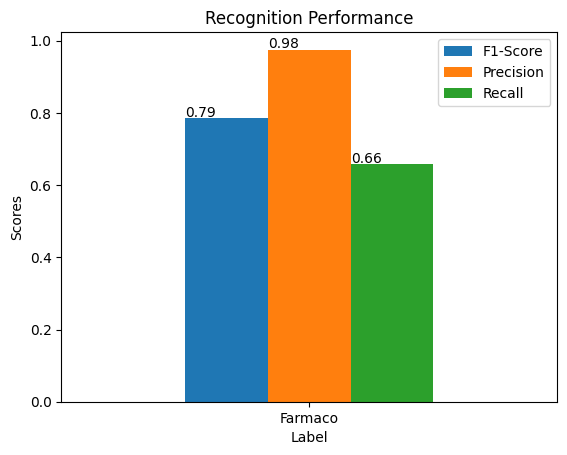

In [16]:
# Creating bar graphic
import matplotlib.pyplot as plt
ax = df.plot.bar(rot=0)

for p in ax.patches:
    ax.annotate('{:.2f}'.format(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

#
plt.title('Recognition Performance')
plt.xlabel('Label')
plt.ylabel('Scores')
plt.show()

### Example

Example of medical recognition with newly trained model. We can see that Spinraza and Nusinersena were recognized as "Farmaco". 

In [17]:
import spacy
nlp_ner = spacy.load("content/model-best")

In [20]:
sentence = """
 Sim, através da portaria nº 24, de 24 de abril de 2019, Sistema Único de Saúde incorporou o medicamento
 Spinraza ® (Nusinersena) para o tratamento da AME tipo 1, não havendo, até o momento, outras alternativas
 de medicamentos ou possibilidades terapêuticas, exceto as paliativas.
 (...)
 Nunca será demais ressaltar que essa doença é grave e rapidamente progressiva, resultando fatal (sic) e
 trazendo grande sofrimento a seus portadores (a quase totalidade conscientes e impotentes diante das
 complicações) e aos familiares deles.
 Venho, com base na irrefutabilidade dos fatos e dados aqui apresentados, rogar à consciência de V.Ex.ª que não
 mais permita a ocorrência de atrasos ao tratamento do autor a partir de demandas fúteis, irrelevantes e
 inconsequentes, como essa que ora findo resposta (...)".
"""
sentence = sentence.replace('  ', ' ')

In [21]:
# Code to visually mark the entities in the text 
doc = nlp_ner(sentence)
colors = {
    "FARMACO": "#89CFF0"
}
options = {"ents": ["FARMACO"], "colors": colors}

spacy.displacy.render(doc, style="ent", options=options, jupyter=True)

In [22]:
import pandas as pd
# Extracting the entities found
entidades = []
classes = []
for ent in doc.ents:
    entidades.append(ent.text)
    classes.append(ent.label_)

# Create a dataframe with the recognized entities
df = pd.DataFrame({"Entidade": entidades, "Classe": classes})
df

,Entidade,Classe
0,Spinraza,Farmaco
1,Nusinersena,Farmaco
